# Langgraph Controllability Concepts

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from langchain_google_genai import GoogleGenerativeAI
llm = GoogleGenerativeAI(model="gemini-2.5-flash")

In [ ]:
from typing import TypedDict

class State(TypedDict):
    state: str

In [12]:
def node_a(state: State) -> State:
    print('--Node A--')
    state['state']+='a'

def node_b(state: State) -> State:
    print('--Node B--')
    state['state']+='b'

def node_c(state: State) -> State:
    print('--Node C--')
    state['state']+='c'

def node_d(state: State) -> State:
    print('--Node D--')
    state['state']+='d'

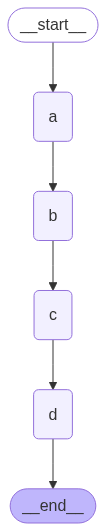

In [16]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
builder = StateGraph(State)

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State):
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, 'a')
builder.add_edge('a', 'b')
builder.add_edge('b', 'c')
builder.add_edge('c', 'd')
builder.add_edge('d', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

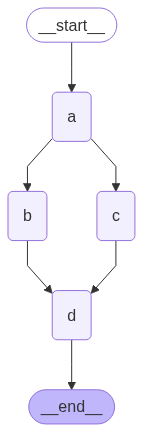

In [18]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
graph.invoke({'state': []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]


InvalidUpdateError: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

### use reducers to overcome this

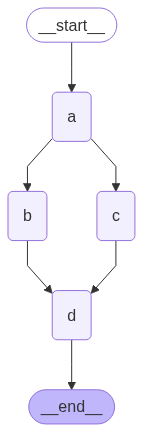

In [20]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
graph.invoke({'state': []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

### wait for nodes to settle

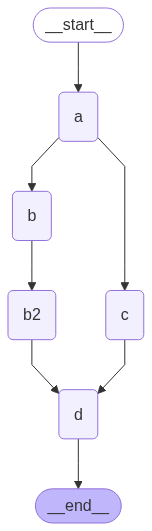

In [22]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

### set custom order of execution

#### how? using custom reducer

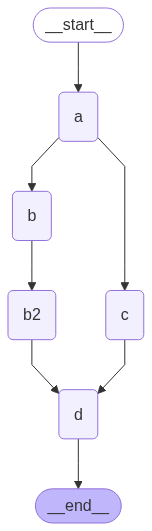

In [24]:
def asc_sort_reducer(left, right):
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    state: Annotated[list, asc_sort_reducer]

builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
graph.invoke({'state': []})

Adding I'm A to []
Adding I'm C to ["I'm A"]
Adding I'm B to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}